In [1]:
# Use Erdos_Spring_2025 conda env as created
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [3]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


In [4]:
def compare_models_with_tuning(df, col, test_size=0.2, random_state=1205):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    models = {
        "GradientBoosting": (GradientBoostingClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.85, 1.0],
            'min_samples_split': [2, 5, 10]
        }),
        "RandomForest": (RandomForestClassifier(random_state=random_state), {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4, 8]
        }),
        "XG Boost Classifier": (xgb.XGBClassifier(objective='reg:squarederror', random_state=random_state),{
           'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 0.85, 1.0] 
        })
    }


    results = {
        'Model': [],
        'Train Accuracy': [],
        'Test Accuracy': []
    }

    for name, (model, param_grid) in models.items():
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)

        results['Model'].append(name)
        results['Train Accuracy'].append(acc_train * 100)
        results['Test Accuracy'].append(acc_test * 100)

        print(f"{name} - Best Params: {grid.best_params_}")
        print(f"Train Accuracy: {acc_train * 100:.2f}%")
        print(f"Test Accuracy: {acc_test * 100:.2f}%")
        print("-" * 30)
        
    # === Add Mean Model (Most Frequent Class) ===
    dummy_mean = DummyClassifier(strategy="most_frequent", random_state=random_state)
    dummy_mean.fit(X_train, y_train)
    acc_train_mean = accuracy_score(y_train, dummy_mean.predict(X_train))
    acc_test_mean = accuracy_score(y_test, dummy_mean.predict(X_test))

    results['Model'].append("Mean (Most Frequent)")
    results['Train Accuracy'].append(acc_train_mean * 100)
    results['Test Accuracy'].append(acc_test_mean * 100)
    
    print(f"Mean (Most Frequent)")
    print(f"Train Accuracy: {acc_train_mean * 100:.2f}%")
    print(f"Test Accuracy: {acc_test_mean * 100:.2f}%")
    print("-" * 30)

    # === Add Random Model (Uniform Sampling) ===
    dummy_random = DummyClassifier(strategy="uniform", random_state=random_state)
    dummy_random.fit(X_train, y_train)
    acc_train_random = accuracy_score(y_train, dummy_random.predict(X_train))
    acc_test_random = accuracy_score(y_test, dummy_random.predict(X_test))

    results['Model'].append("Random")
    results['Train Accuracy'].append(acc_train_random * 100)
    results['Test Accuracy'].append(acc_test_random * 100)
    
    print(f"Random")
    print(f"Train Accuracy: {acc_train_random * 100:.2f}%")
    print(f"Test Accuracy: {acc_test_random * 100:.2f}%")
    print("-" * 30)

    # Create DataFrame for plotting
    df_result = pd.DataFrame(results)

    # Melt for plotting with seaborn
    df_plot = df_result.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Accuracy', y='Model', hue='Dataset', palette='Set2')
    #plt.title("Model Comparison: Train vs Test Accuracy")
    plt.xlabel("Accuracy (%)")
    plt.legend(title='Dataset', loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    plt.xlim(0, 105)
    plt.tight_layout()
    plt.show()

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 1.0}
Train Accuracy: 69.77%
Test Accuracy: 70.08%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 200}
Train Accuracy: 70.21%
Test Accuracy: 70.05%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.85}
Train Accuracy: 69.74%
Test Accuracy: 70.08%
------------------------------
Mean (Most Frequent)
Train Accuracy: 65.19%
Test Accuracy: 65.15%
------------------------------
Random
Train Accuracy: 49.78%
Test Accuracy: 50.08%
------------------------------


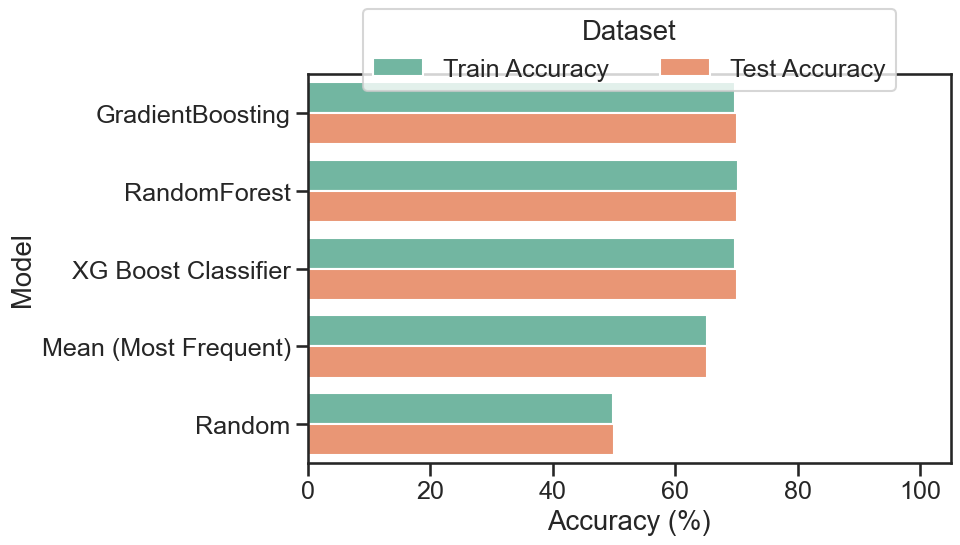

In [5]:
best_p = [{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0},\
    {'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 200},\
    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.85}]

compare_models_with_tuning(df, 'dry_eye_disease')

Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.7}
Train Accuracy: 53.26%
Test Accuracy: 53.02%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Train Accuracy: 81.79%
Test Accuracy: 52.20%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Train Accuracy: 53.29%
Test Accuracy: 53.10%
------------------------------
Mean (Most Frequent)
Train Accuracy: 53.03%
Test Accuracy: 53.10%
------------------------------
Random
Train Accuracy: 49.58%
Test Accuracy: 49.18%
------------------------------


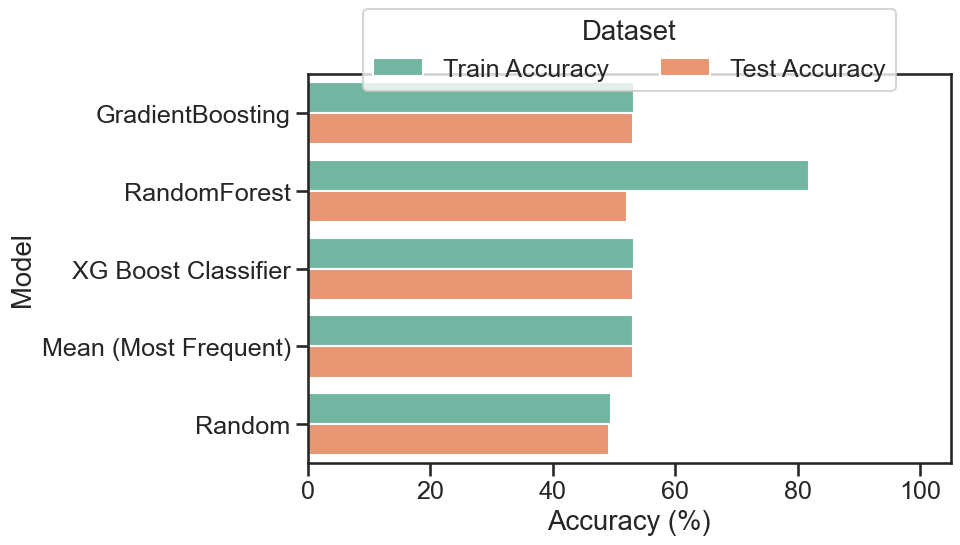

In [6]:
compare_models_with_tuning(df, 'insomnia')

In [7]:
df = df0.copy()
df = df[(df['combined_condition']=='both') | (df['combined_condition']=='none')]
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'dry_eye_disease', 'insomnia']
df = df.drop(columns=omit_cols)


['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


Tuning GradientBoosting...
GradientBoosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.85}
Train Accuracy: 67.88%
Test Accuracy: 69.41%
------------------------------
Tuning RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 500}
Train Accuracy: 68.41%
Test Accuracy: 69.35%
------------------------------
Tuning XG Boost Classifier...
XG Boost Classifier - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.85}
Train Accuracy: 67.96%
Test Accuracy: 69.41%
------------------------------
Mean (Most Frequent)
Train Accuracy: 61.92%
Test Accuracy: 63.51%
------------------------------
Random
Train Accuracy: 49.86%
Test Accuracy: 53.12%
------------------------------


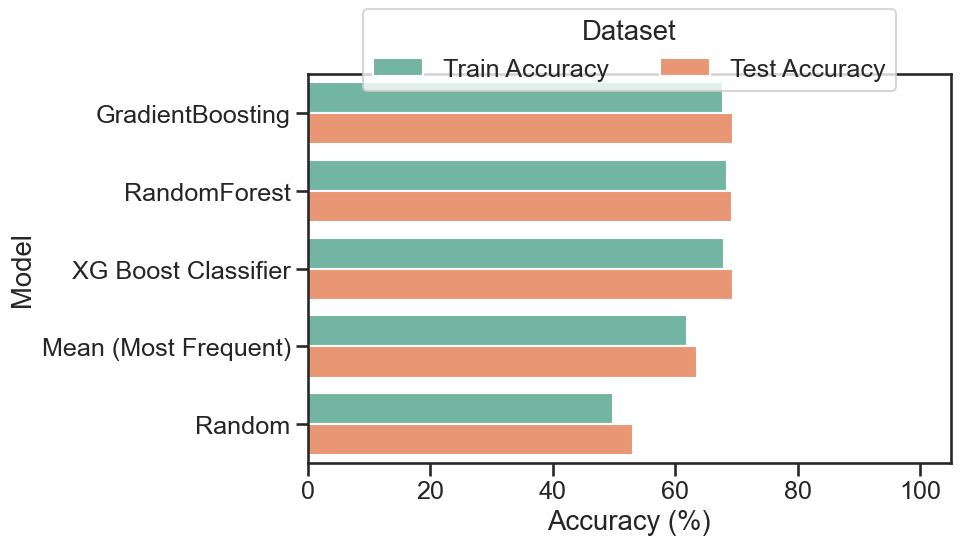

In [8]:
compare_models_with_tuning(df, 'combined_condition')